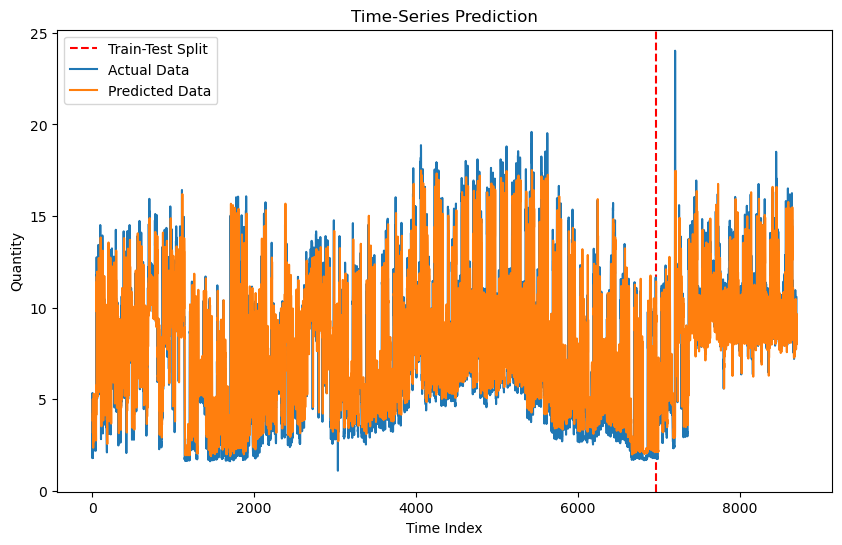

In [11]:
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 1
hidden_size = 2
num_layers = 1
output_size = 1

# Load model
loaded_lstm = LSTM(input_size, hidden_size, output_size, num_layers)

# Load model state dict
loaded_lstm.load_state_dict(torch.load('lstm_model_state_dict.pth', map_location=torch.device('cpu')))
loaded_lstm.eval()

# Load the data into a pandas DataFrame
data = pd.read_csv('merged_lz_houston_data.csv', parse_dates=['DateTime'])

# Ensure 'Settlement Point Price' and 'QUANTITY' are treated as numeric columns.
# Coerce any errors during conversion to NaN, which will be handled during the filling process.
# Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
data['Settlement_Point_Price'] = pd.to_numeric(data['Settlement Point Price'], errors='coerce')
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
data.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order
data.sort_index(inplace=True)

# Resample the data to hourly frequency, aggregating with the mean
# Only numeric columns should be included in this operation.

# Should not Average the Data here, they are separate datasets
account_b_data = data[data["ACCOUNT_NUMBER"] == "account_b"][['Settlement_Point_Price', 'QUANTITY']]
account_a_data = data[data["ACCOUNT_NUMBER"] == "account_a"][['Settlement_Point_Price', 'QUANTITY']]

account_b_data = account_b_data.dropna()
account_a_data = account_a_data.dropna()

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Scale your data using MinMaxScaler to help the LSTM converge faster
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(account_a_data[['QUANTITY']].values)

# Convert the dataset into sequences of a specific window size
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Define the sequence length (number of time steps to look back) and create sequences
seq_length = 4
x, y = sliding_windows(data_scaled, seq_length)

# Convert to PyTorch tensors
dataX = torch.Tensor(x)
dataY = torch.Tensor(y)

# Define the number of splits for cross-validation
n_splits = 4  # For example, you can choose 4-fold cross-validation

# TimeSeriesSplit provides train/test indices to split time series data samples
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate over each split
for fold, (train_index, test_index) in enumerate(tscv.split(dataX)):
    # Create training and testing sets for this fold
    trainX, trainY = dataX[train_index], dataY[train_index]
    testX, testY = dataX[test_index], dataY[test_index]

    # Create DataLoader instances for training and testing sets
    batch_size = 64  # You can adjust the batch size
    train_dataset = TensorDataset(trainX, trainY)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(testX, testY)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
# Generate predictions for both training and test sets
train_predict = loaded_lstm(trainX.cpu())
test_predict = loaded_lstm(testX.cpu())

# Concatenate train and test predictions for full data visualization
full_predict = torch.cat((train_predict, test_predict), 0)

# Inverse transform the predictions and actual data
data_predict = scaler.inverse_transform(full_predict.data.cpu().numpy())
dataY_plot = scaler.inverse_transform(dataY.data.cpu().numpy())

# Calculate the splitting point in the plot for visualizing train-test separation
split_pt = trainX.size(0) + seq_length  # Account for the sequence length

# Plotting
plt.figure(figsize=(10,6))
plt.axvline(x=split_pt, c='r', linestyle='--', label='Train-Test Split')

# Actual data
plt.plot(dataY_plot, label='Actual Data')

# Predictions (overlay on the actual data)
plt.plot(np.arange(seq_length, len(data_predict)+seq_length), data_predict, label='Predicted Data')

plt.title('Time-Series Prediction')
plt.xlabel('Time Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()

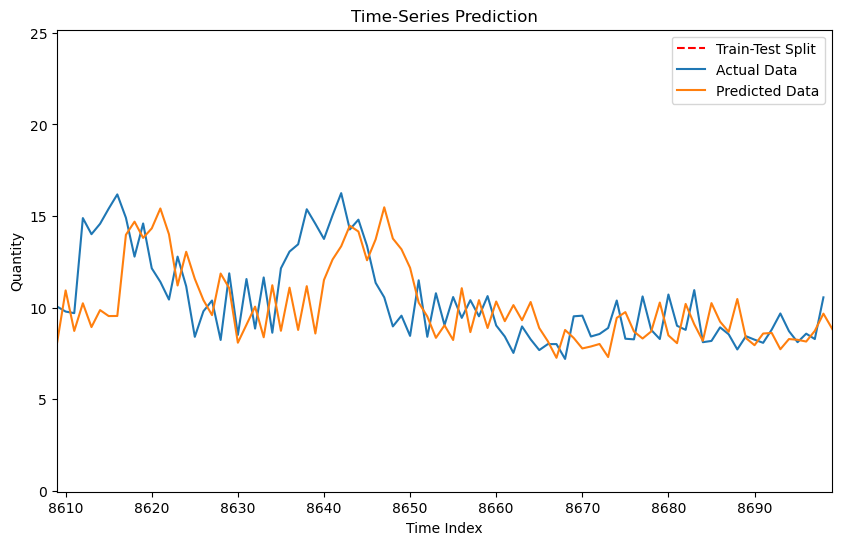

In [18]:
import matplotlib.pyplot as plt
import numpy as np

#Assuming data_predict and dataY_plot are the predicted and actual data, respectively
# Calculate the splitting point in the plot for visualizing train-test separation

plt.figure(figsize=(10,6))
plt.axvline(x=split_pt, c='r', linestyle='--', label='Train-Test Split')


plt.plot(dataY_plot, label='Actual Data')

# Predictions (overlay on the actual data)
plt.plot(np.arange(seq_length, len(data_predict)+seq_length), data_predict, label='Predicted Data')

# Set the title and labels
plt.title('Time-Series Prediction')
plt.xlabel('Time Index')
plt.ylabel('Quantity')

# Set the legend
plt.legend()

last_three_months_start = len(dataY_plot) - 90  # 90 days in the last three months

# Zoom in on the last three months
plt.xlim(last_three_months_start, len(dataY_plot))

plt.show()